# The UCI Breast Cancer Wisconsin

### Import libraries

In [1]:
from ucimlrepo import fetch_ucirepo
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import seaborn as sns

### Preparing the datasets

In [2]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

test_sizes = [.6, .4, .2, .1]
datasets = {}
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=22125, stratify=y)
    datasets[test_size] = {
        "feature_train": X_train,
        "feature_test": X_test,
        "label_train": y_train,
        "label_test": y_test
    }

### Visualizing the data

#### Histogram plot function

In [3]:
from matplotlib.axes import Axes

def plot_distribution(ax: Axes, data, title):
    unique, counts = np.unique(data, return_counts=True)
    total_count = sum(counts)  
    frequencies = counts / total_count

    bars = ax.bar(unique, counts, edgecolor='black', label='Count')
    ax.set_ylabel('Count')
    ax.tick_params(axis='y')

    for bar, count, freq in zip(bars, counts, frequencies):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total_count / 569 * 5,
                f'{count} ({freq*100:.2f}%)', ha='center', color='darkgreen', fontsize=10)

    ax2 = ax.twinx()
    ax2.plot(unique, frequencies, color='red', marker=' ', linestyle=' ', label='Frequency')
    ax2.set_ylabel('Frequency')
    ax2.tick_params(axis='y')
    ax2.grid(visible=True, linestyle='--', linewidth=0.5)

    ax.set_title(title)

#### Visualizing the distribution of the target variable in each subset

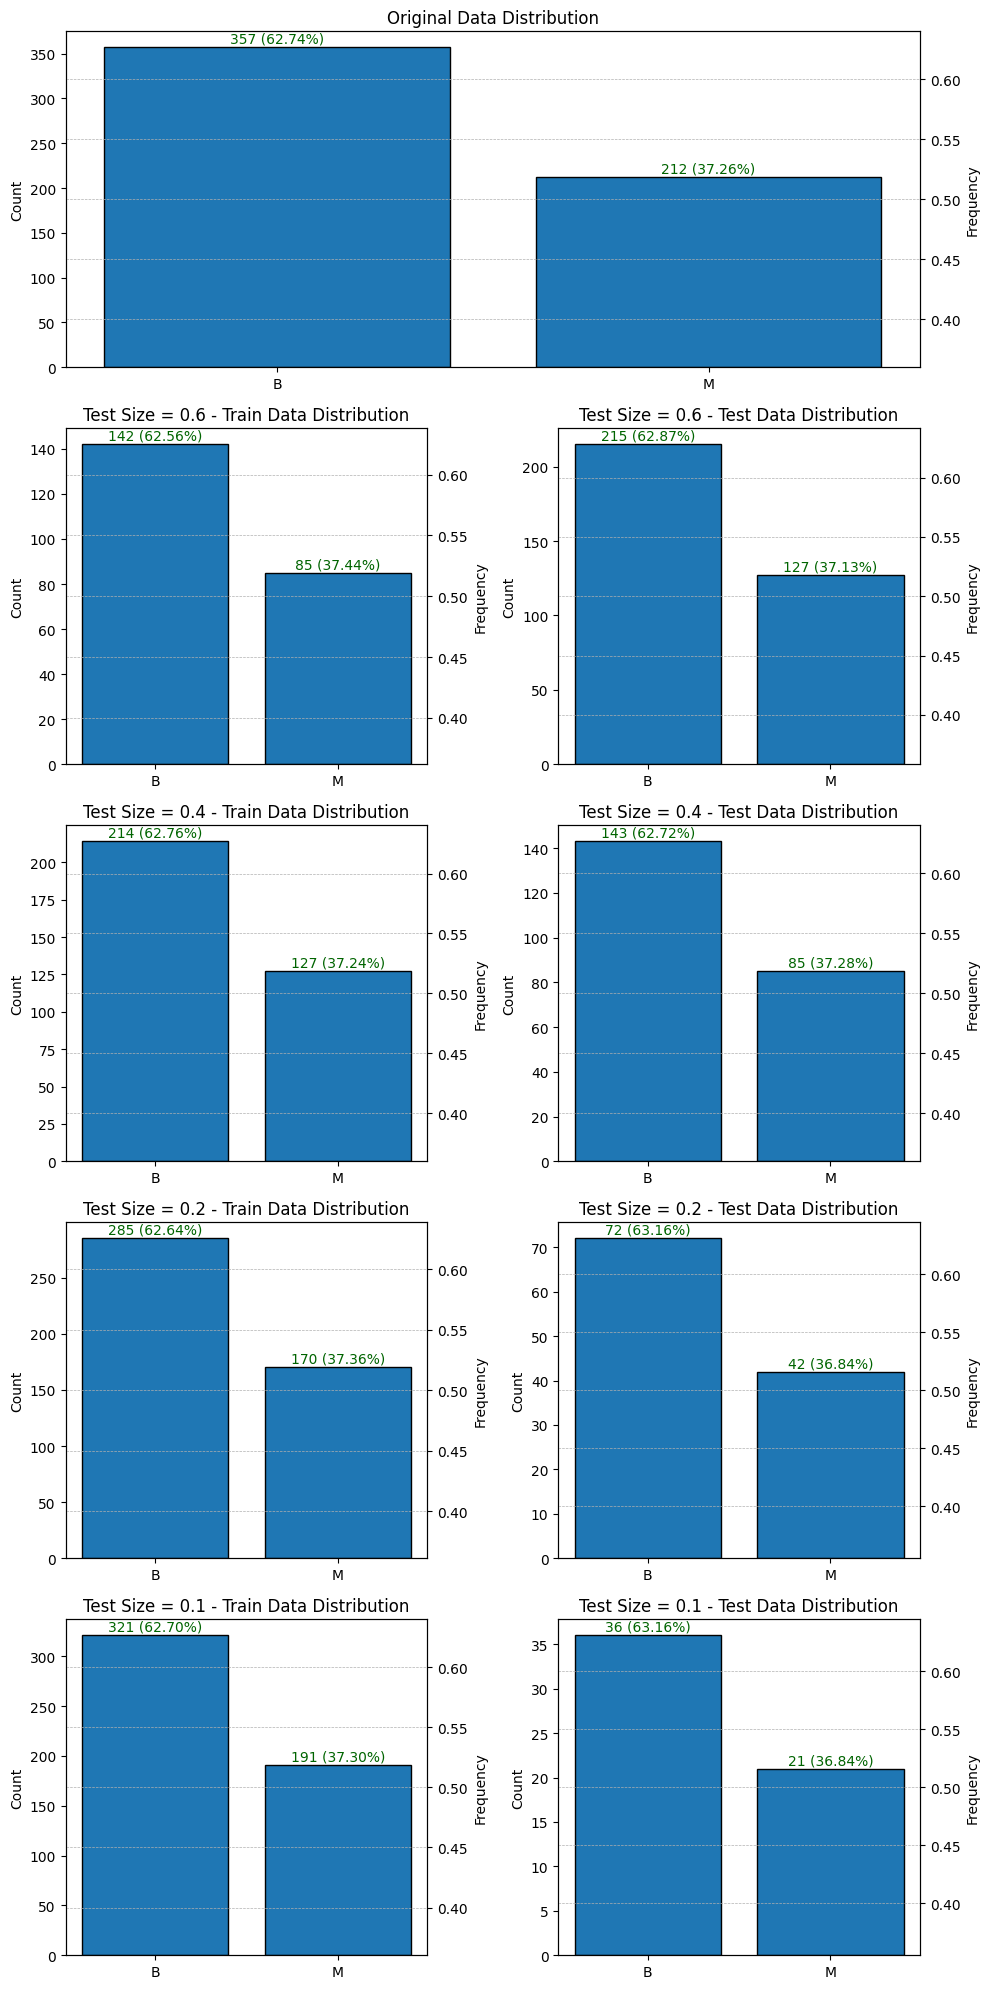

In [4]:
fig = plt.figure(figsize=(10, 20))
gs = gridspec.GridSpec(5, 2, figure=fig)

# Original data distribution
ax = fig.add_subplot(gs[0, :])
plot_distribution(ax, y, 'Original Data Distribution')

# Data distribution for each test size
for i, (test_size, data) in enumerate(datasets.items(), 1):
    ax = fig.add_subplot(gs[i, 0])
    plot_distribution(ax, data['label_train'], f'Test Size = {test_size} - Train Data Distribution')

    ax = fig.add_subplot(gs[i, 1])
    plot_distribution(ax, data['label_test'], f'Test Size = {test_size} - Test Data Distribution')

plt.tight_layout()
plt.show()

### Building the decision tree classifiers

#### Build trees

In [5]:
decision_trees = {
    test_size: 
        DecisionTreeClassifier(random_state=22125, criterion='entropy')
        .fit(data["feature_train"], data["label_train"])
    for test_size, data in datasets.items()
}

#### Tree visualizations

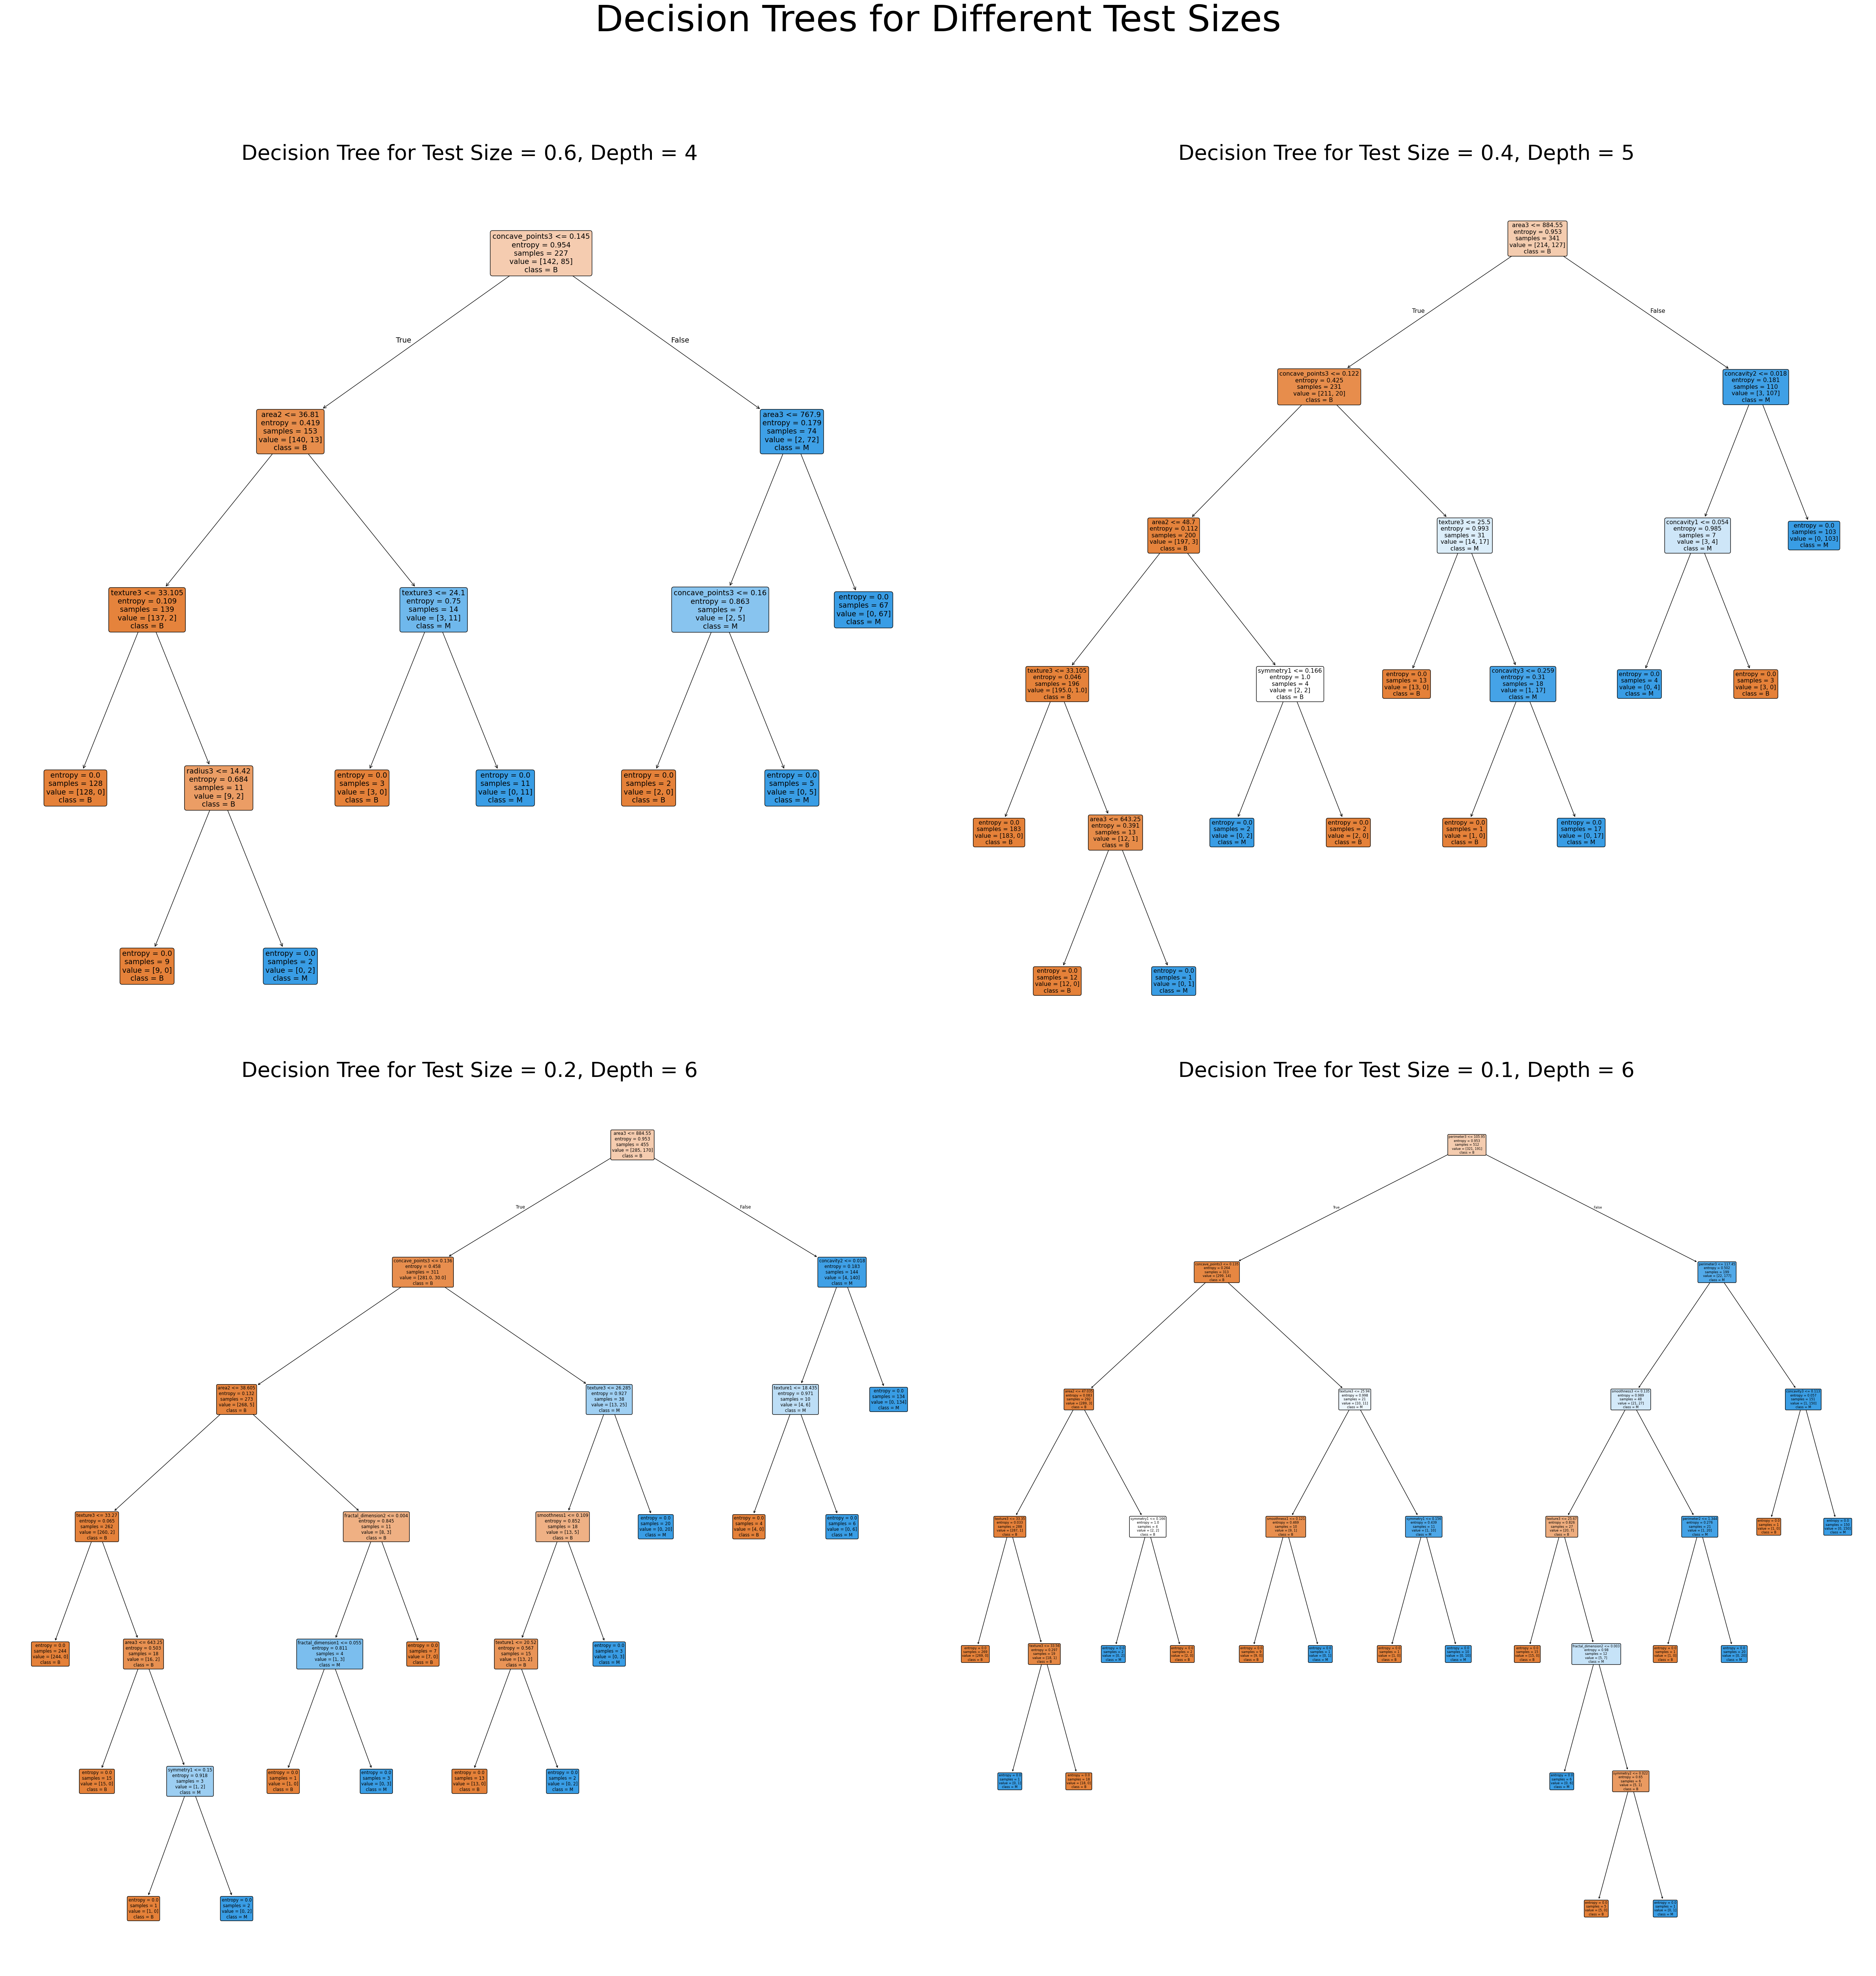

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(50, 50))

for ax, (test_size, tree) in zip(axs.ravel(), decision_trees.items()):
    plot_tree(tree, 
              feature_names=X.columns, 
              class_names=tree.classes_, 
              filled=True, 
              rounded=True, 
              ax=ax)
    ax.set_title(f'Decision Tree for Test Size = {test_size}, Depth = {tree.get_depth()}', fontsize=40)
fig.suptitle('Decision Trees for Different Test Sizes', fontsize=70, y=1.05)
plt.tight_layout()
plt.show()

### Evaluating the decision tree classifiers

#### Prepare the results

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

classification_reports = {}
confusion_matrices = {}
for test_size, data in datasets.items():
    y_true = data['label_test']
    y_pred = decision_trees[test_size].predict(data['feature_test'])
    
    classification_reports[test_size] = classification_report(y_true, y_pred)
    confusion_matrices[test_size] = confusion_matrix(y_true, y_pred)

#### Classification report

In [8]:
for test_size, classification_report_str in classification_reports.items():
    print(f'Classification Report for Test Size = {test_size}')
    print(classification_report_str)

Classification Report for Test Size = 0.6
              precision    recall  f1-score   support

           B       0.94      0.94      0.94       215
           M       0.90      0.89      0.89       127

    accuracy                           0.92       342
   macro avg       0.92      0.91      0.92       342
weighted avg       0.92      0.92      0.92       342

Classification Report for Test Size = 0.4
              precision    recall  f1-score   support

           B       0.94      0.92      0.93       143
           M       0.87      0.89      0.88        85

    accuracy                           0.91       228
   macro avg       0.90      0.91      0.91       228
weighted avg       0.91      0.91      0.91       228

Classification Report for Test Size = 0.2
              precision    recall  f1-score   support

           B       0.95      0.88      0.91        72
           M       0.81      0.93      0.87        42

    accuracy                           0.89       114
  

#### Confusion matrixes

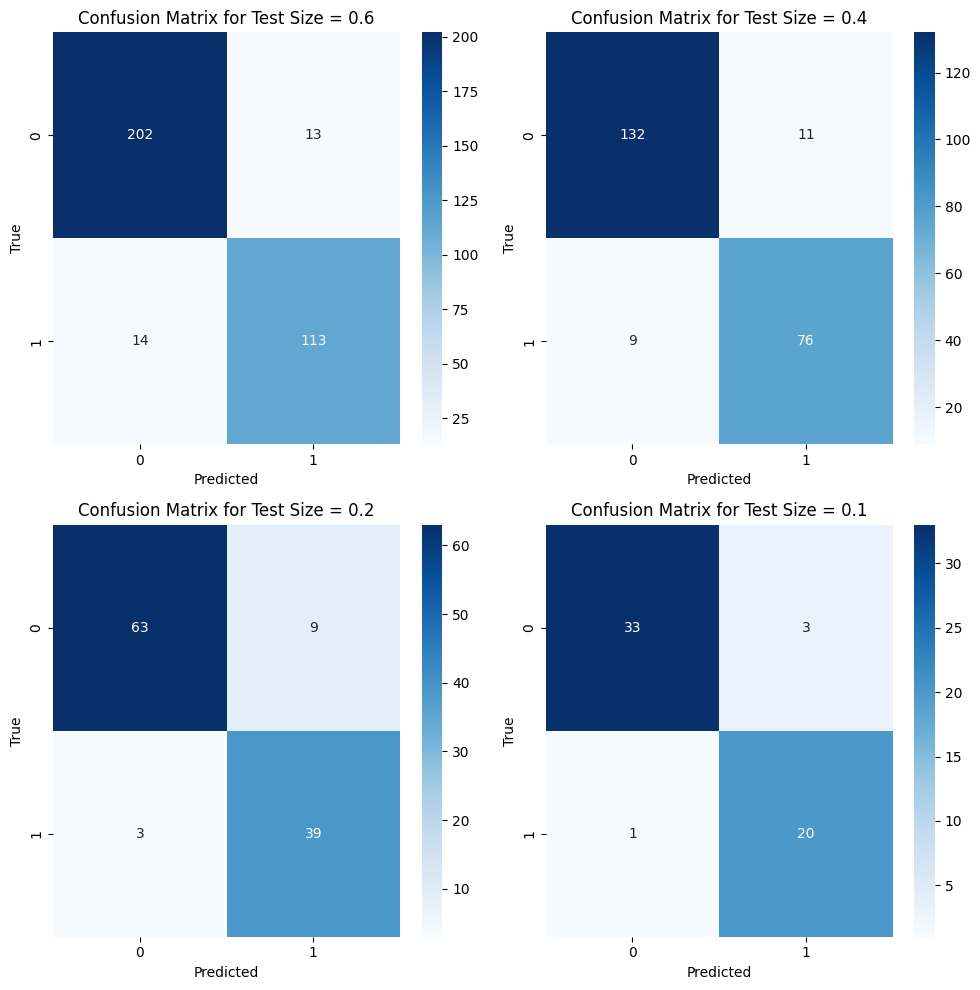

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for ax, (test_size, confusion_matrix_data) in zip(axs.ravel(), confusion_matrices.items()):
    sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for Test Size = {test_size}', fontsize=12)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    
plt.tight_layout()

### The depth and accuracy of a decision tree

#### Prepare trees

In [10]:
tree = decision_trees[0.2]
dataset = datasets[0.2]
max_depth = tree.get_depth()
tree_depths = {}

tree_depths[f'None ({max_depth})'] = tree

for i in range(2, max(max_depth + 1, 8)):
    tree = DecisionTreeClassifier(random_state=22125, criterion='entropy', max_depth=i)
    tree.fit(dataset['feature_train'], dataset['label_train'])
    tree_depths[i] = tree

#### Plot tree with different depths

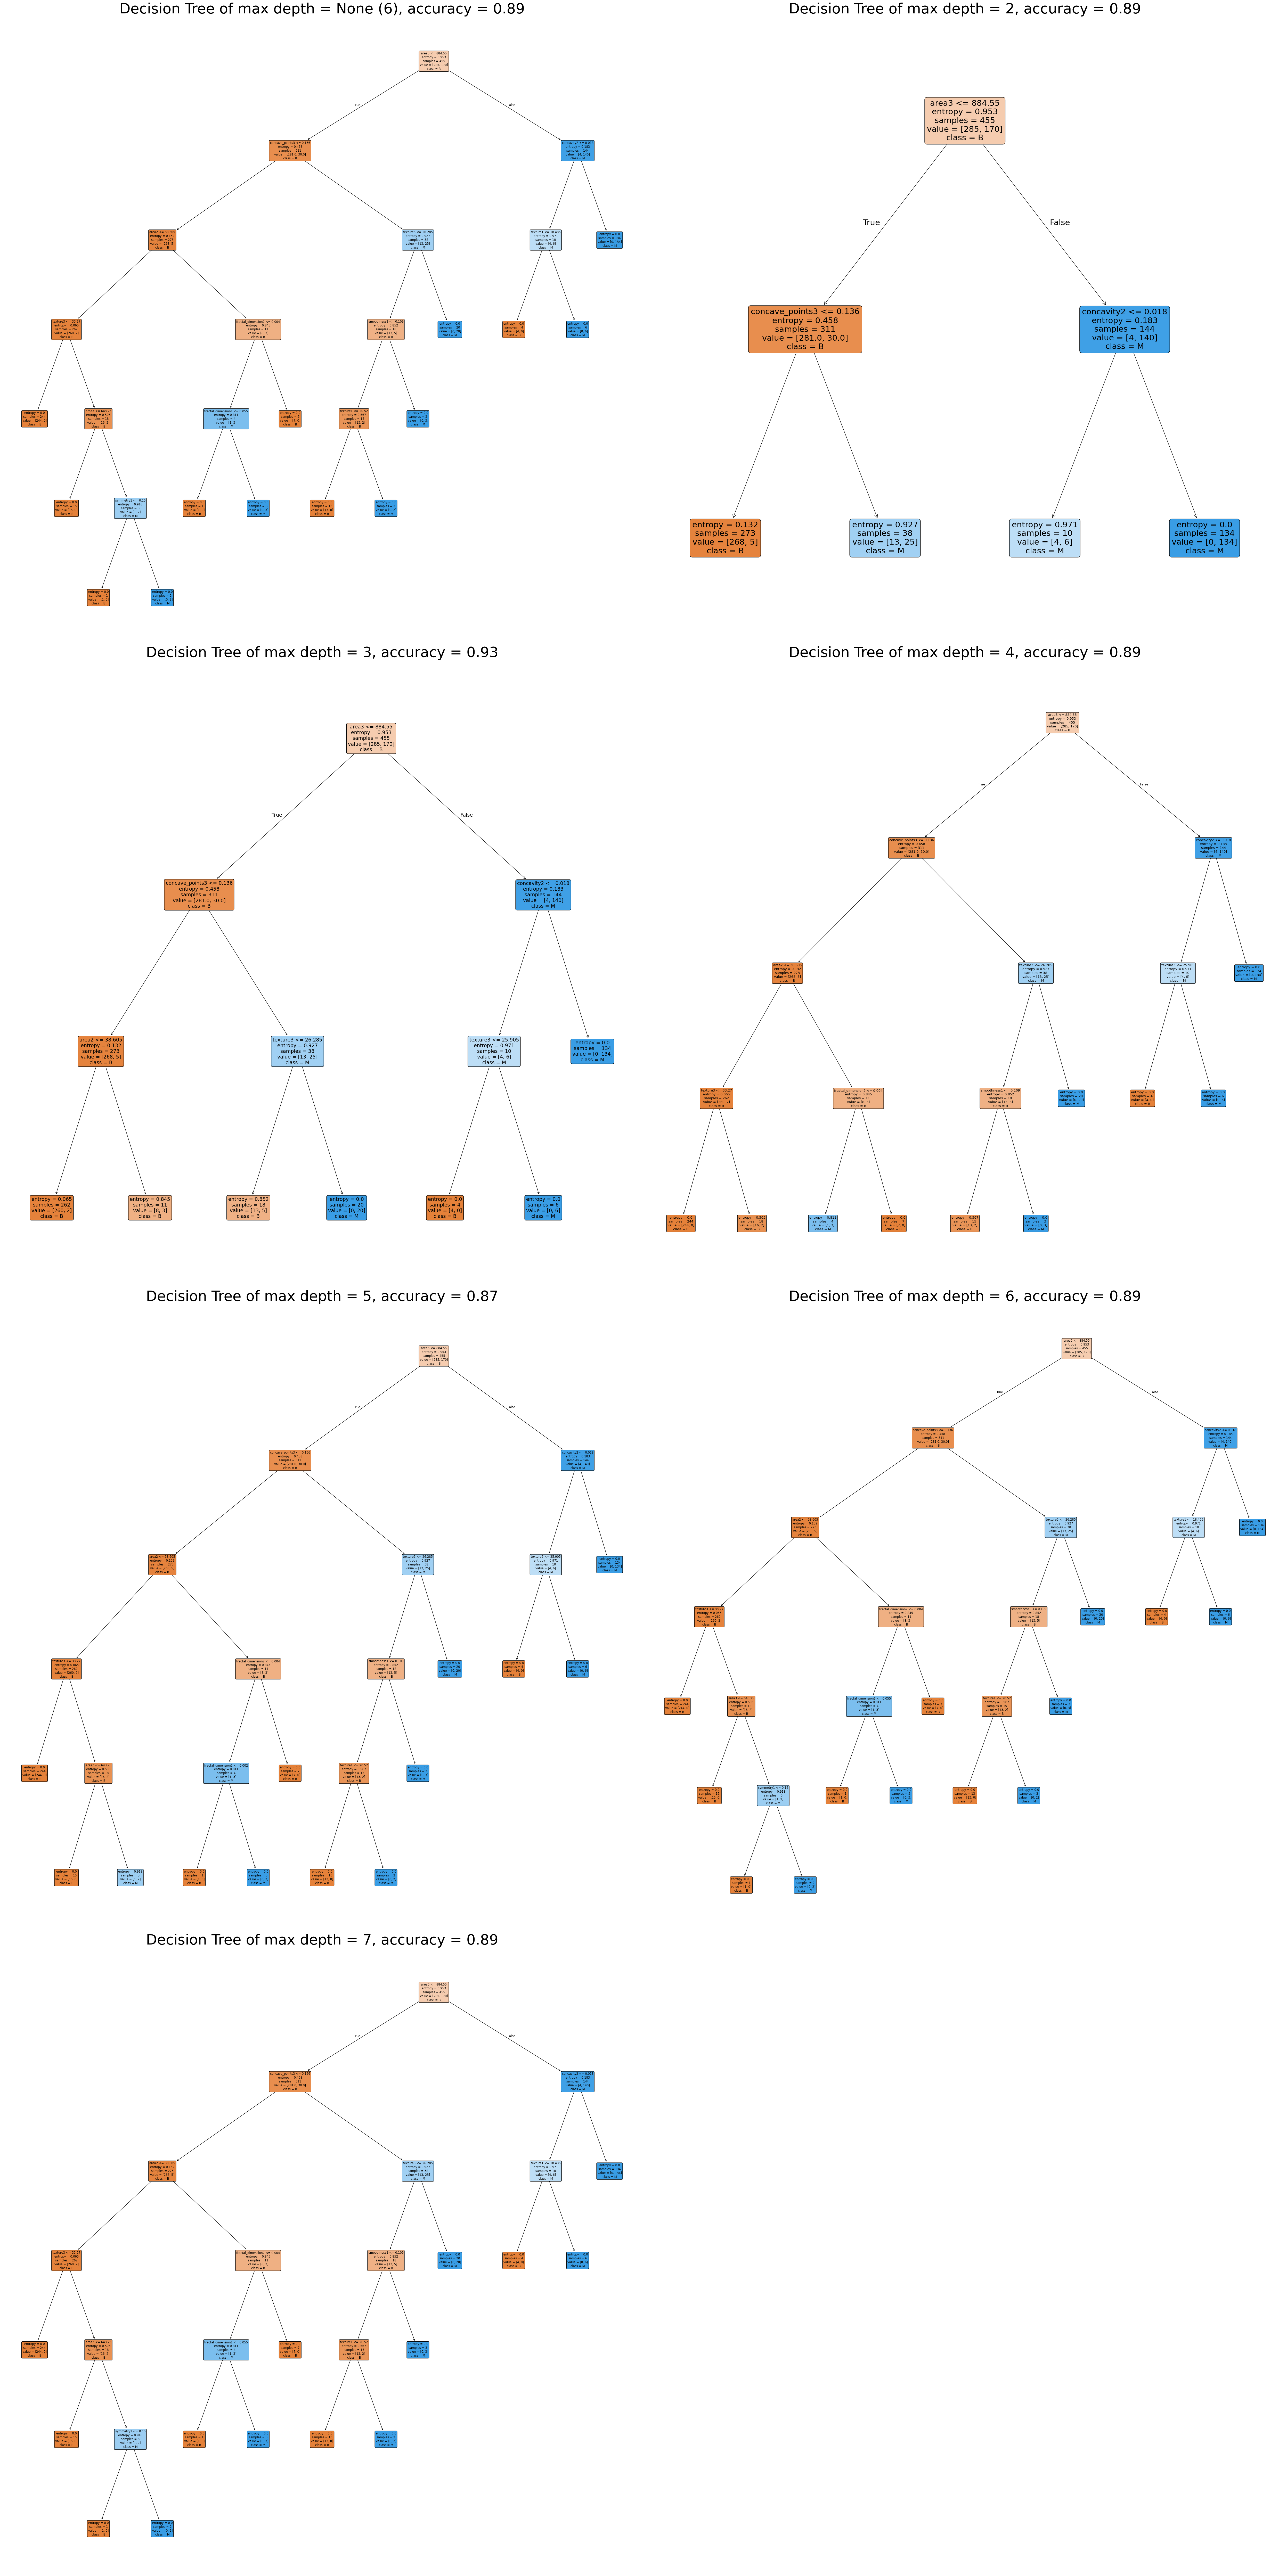

In [11]:
fig, axs = plt.subplots(4, 2, figsize=(50, 100))

for ax, (depth, tree), _ in zip(axs.ravel(), tree_depths.items(), range(7)):
    plot_tree(tree, 
              feature_names=X.columns, 
              class_names=tree.classes_, 
              filled=True, 
              rounded=True,
              ax=ax)
    ax.set_title(f'Decision Tree of max depth = {depth}, accuracy = {tree.score(dataset["feature_test"], dataset["label_test"]):.2f}', fontsize=40)
axs[-1, -1].axis('off')

plt.tight_layout()

#### Plot accuracy with different depths

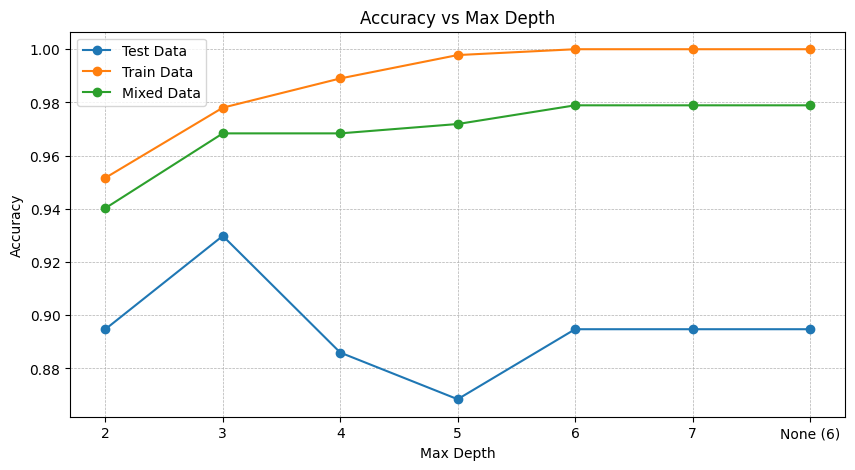

In [12]:
def get_accuracy(data_feature, data_label):
    acc = [(depth, tree.score(data_feature, data_label)) for depth, tree in tree_depths.items()]
    return acc[1:] + acc[:1]

test_data = get_accuracy(dataset['feature_test'], dataset['label_test'])
train_data = get_accuracy(dataset['feature_train'], dataset['label_train'])
mixed_data = get_accuracy(X, y)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(*zip(*test_data), label='Test Data', marker='o')
ax.plot(*zip(*train_data), label='Train Data', marker='o')
ax.plot(*zip(*mixed_data), label='Mixed Data', marker='o')
ax.set_xlabel('Max Depth')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Max Depth')
ax.legend()
ax.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()